Datacamp LDA example from:

https://campus.datacamp.com/courses/fraud-detection-in-python/fraud-detection-using-text?ex=8

LDA yields 2 Dirichlet distributions:
1. Topics per text item (probabilities)
2. Words per topic

Implementation
1. Clean the data
2. Dictionary: which words appear how often in all of the text, Corpus: for each text line, the count of words that appear.
3. Dictionary and corpus are the input of the LDA model
4. Run the LDA model

Results:
1. How each word in the data is associated with each topic
2. How each text item associates with topics

In [158]:
import gensim
from gensim import corpora
from gensim.parsing.preprocessing import preprocess_string
import pandas as pd
from random import sample 
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt 

%matplotlib inline

## Load and clean the data

* Load the metadata downloaded from archive
* Keep only papers on natural language processing: original category 'cs.CL' (Computation and Language)
* Load abstracts, merge with metadata dataframe
* Check that all entries have an abstract
* Keep only research papers (research papers are papers that are not review papers).


In [80]:
%%time

# Load the metadata downloaded from archive
arxiv_metadata = pd.read_csv('../data/arxiv_metadata.csv.zip', index_col=0)

<timed exec>:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 8.69 s, sys: 746 ms, total: 9.44 s
Wall time: 9.44 s


In [81]:
# Keep only papers on natural language processing: original category 'cs.CL' (Computation and Language)
nlp_idx = ['cs.CL' in subject for subject in arxiv_metadata['categories']]
arxiv_nlp = arxiv_metadata[nlp_idx]

In [82]:
%%time

# load abstracts extracted data in notebook 00_load_abstracts
arxiv_abstracts = pd.read_csv('../data/arxiv_abstracts.csv.zip', index_col=0)

<timed exec>:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 9.32 s, sys: 802 ms, total: 10.1 s
Wall time: 10.1 s


In [83]:
# merge with metadata dataframe
arxiv_abstracts_nlp = arxiv_abstracts[arxiv_abstracts.id.isin(arxiv_nlp.id)]
arxiv_nlp_merged = pd.merge(arxiv_nlp, arxiv_abstracts_nlp, on='id')

In [84]:
# check that all entries have an abstract
idx = arxiv_nlp_merged['abstract'].isna()
arxiv_nlp_merged = arxiv_nlp_merged[~idx]

In [85]:
# Keep only research papers (research papers are papers that are not review papers).
research_paper_idx = ['systematic literature review' not in abstract.lower() for abstract in arxiv_nlp_merged.abstract]
arxiv_nlp_merged = arxiv_nlp_merged[research_paper_idx]

In [144]:
print(f"There are {len(arxiv_nlp_merged)} research papers on NLP with an abstract in the dataset.")

There are 55943 research papers on NLP with an abstract in the dataset.


## Split the data into train / test / validate datasets

In [153]:
arxiv_nlp_train, arxiv_nlp_test = train_test_split(arxiv_nlp_merged, test_size=0.2, train_size=0.8)
arxiv_nlp_train, arxiv_nlp_validate = train_test_split(arxiv_nlp_merged, test_size=0.2, train_size=0.8)
print(f"The train dataset has {arxiv_nlp_train.shape[0]} rows, the test dataset {arxiv_nlp_test.shape[0]}, the validation dataset {arxiv_nlp_validate.shape[0]}")

The train dataset has 1000 rows, the test dataset 11189, the validation dataset 11189


## Clean the data

Apply default pre-processing filters:
strip_tags, strip_punctuation, strip_multiple_whitespaces, stric_numeric, remove_stopwords; strip_short, stem_text

see: https://github.com/piskvorky/gensim/blob/develop/gensim/parsing/preprocessing.py

In [154]:
def clean(abstracts):
    texts = [
        preprocess_string(text)
        for text in abstracts
    ]
    return texts

texts_train = clean(arxiv_nlp_train['abstract'])
texts_test = clean(arxiv_nlp_test['abstract'])
texts_validate = clean(arxiv_nlp_validate['abstract'])

## Create dictionary and corpus

In [155]:
def dict_corpus(texts):
    # Dictionary of the number of times a word appears in all of the text
    dictionary = corpora.Dictionary(texts)
    # Filter out uncommon words, keep the most common words
    dictionary.filter_extremes(no_below=5, keep_n=50000)
    # Corpus uses the bag-of-words format (bow), i.e. each row in the data is a list of words with their associated word counts.
    corpus = [dictionary.doc2bow(text) for text in texts]
    return dictionary, corpus

Create a dictionary and a corpus for each dataset.

In [156]:
dictionary_train, corpus_train = dict_corpus(texts_train)
dictionary_test, corpus_test = dict_corpus(texts_test)
dictionary_validate, corpus_validate = dict_corpus(texts_validate)

## Run the LDA model
Fit the model on the training set, for different values of k.

Validate the model by computing perplexity for different values of k.

Find the k which yields a perplexity closest to 0.

see: https://radimrehurek.com/gensim/models/ldamodel.html

In [173]:
px = []
num_topics = []
max_k = 25
for k in range(2, max_k + 1):
    # Define the LDA model
    ldamodel = gensim.models.ldamodel.LdaModel(corpus_train, num_topics=k, id2word=dictionary_train, passes=15)
    num_topics.append(k)
    px.append(ldamodel.log_perplexity(corpus_train))
perplexity = pd.DataFrame.from_dict({'k': num_topics, 'val': px})

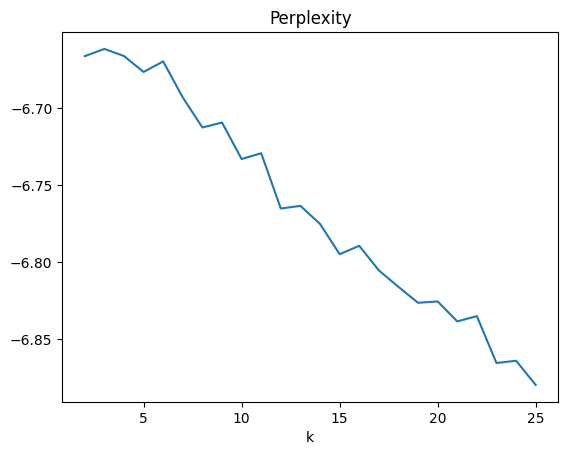

In [184]:
plt.plot(perplexity.k, perplexity.val)
plt.title("Log Perplexity by number of topics")
plt.xlabel("k")
plt.show()

In [187]:
# Find the best k value 
best_k = perplexity.sort_values('val', ascending=False).iloc[0]['k']
best_k

3.0

## Refit the model, with best k

In [188]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus_train, num_topics=best_k, id2word=dictionary_train, passes=15)

Print the topics, with top words

In [189]:
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.017*"task" + 0.015*"train" + 0.012*"data" + 0.012*"perform" + 0.011*"gener"')
(1, '0.015*"task" + 0.012*"base" + 0.011*"word" + 0.011*"text" + 0.010*"propos"')
(2, '0.014*"gener" + 0.010*"base" + 0.009*"question" + 0.008*"evalu" + 0.008*"llm"')


## Visualize the results

In [118]:
#import pyLDAvis.gensim

In [120]:
#lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
#pyLDAvis.display(lda_display)

Best results have:
* non-overlapping bubbles
* large, same-sized bubbles

## Assign topics to the data

Aggregate topic information in a dataframe (see: https://campus.datacamp.com/courses/fraud-detection-in-python/fraud-detection-using-text?ex=11)

In [190]:
def get_topic_details(ldamodel, corpus):
    topic_details_list = []
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_details_list.append([topic_num, prop_topic])
    topic_details_df = pd.DataFrame(topic_details_list)
    topic_details_df.columns = ['Dominant_Topic', '% Score']
    return topic_details_df

In [29]:
# put the original categories data in a dataframe
#contents = pd.DataFrame()
# combine with result of topic details function
#topic_details = get_topic_details(ldamodel, corpus)
#contents['Dominant Topic'] = topic_details['Dominant_Topic']
#contents['% Score'] = topic_details['% Score']
#contents['Original Subject'] = list(arxiv_ml_research_sampled['categories'])

In [30]:
#contents.head(10)

,Dominant Topic,% Score,Original Subject
0,1,0.982688,cs.CY cs.AI
1,1,0.664624,stat.ML cs.LG
2,1,0.987672,cs.AI cs.RO
3,0,0.986132,cs.CL cs.AI
4,1,0.980300,cs.AI cs.LG cs.LO
5,0,0.793473,cs.LG stat.ML
6,1,0.986286,cs.CL cs.AI cs.LG
7,1,0.962259,cs.NE cs.AI cs.LG
8,1,0.543033,cs.LG stat.ML
9,0,0.985164,cs.LG cs.AI


In [59]:
topic_subject_df = pd.DataFrame(columns=['Dominant Topic', 'cs.AI', 'cs.LG'])

# topic 0, AI
id_0 = list(contents['Dominant Topic'] == 0)
id_ai = ['cs.AI' in subject for subject in contents['Original Subject']]
topic_0_ai = sum([a and b for a, b in zip(id_ai, id_0)])

# topic 0, LG
id_lg = ['cs.LG' in subject for subject in contents['Original Subject']]
topic_0_lg = sum([a and b for a, b in zip(id_lg, id_0)])

# topic 1, AI
id_1 = list(contents['Dominant Topic'] == 1)
topic_1_ai = sum([a and b for a, b in zip(id_ai, id_1)])

# topic 1, LG
topic_1_lg = sum([a and b for a, b in zip(id_lg, id_1)])

topic_subject_df = topic_subject_df.from_dict({'Dominant Topic':[0, 1], 'cs.AI': [topic_0_ai, topic_1_ai], 'cs.LG': [topic_0_lg, topic_1_lg]})

In [60]:
topic_subject_df

,Dominant Topic,cs.AI,cs.LG
0,0,17,30
1,1,17,51
